This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

#start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Sep  9 06:00:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! pip install tensorflow==1.15.5
! pip install keras==2.0.8 
! pip install tensorflow-gpu==1.15.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c 'cdiscount-image-classification-challenge' -f train.bson

100% 47.2G/47.2G [05:17<00:00, 151MB/s]
100% 47.2G/47.2G [05:17<00:00, 160MB/s]


In [ ]:
!kaggle competitions download -c 'cdiscount-image-classification-challenge' -f category_names.csv

  0% 0.00/406k [00:00<?, ?B/s]
100% 406k/406k [00:00<00:00, 102MB/s]


In [ ]:
!unzip /content/train.bson.zip

Archive:  /content/train.bson.zip
  inflating: train.bson              


In [ ]:
!rm /content/train.bson.zip

In [ ]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


category_names.csv
drive
kaggle.json
sample_data
train.bson



In [ ]:
keras.__version__, tf.__version__

('2.0.8', '1.15.5')

In [ ]:
import tensorflow as tf
print(tf.__version__, tf.test.is_gpu_available())

1.15.5 True


In [ ]:
data_dir = "/content"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

# Part 1: Create lookup tables

The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

You only need to generate these tables once, as they get saved to CSV files. If you already have these CSV files, skip to part 2.

## Lookup table for categories

In [ ]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


Create dictionaries for quick lookup of `category_id` to `category_idx` mapping.

In [ ]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [ ]:
cat2idx, idx2cat = make_category_tables()

NameError: ignored

In [ ]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

## Read the BSON files

We store the offsets and lengths of all items, allowing us random access to the items later.

Inspired by code from: https://www.kaggle.com/vfdev5/random-item-access

Note: this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).

In [ ]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [ ]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [10:21<00:00, 11380.28it/s]


CPU times: user 1min 28s, sys: 25.7 s, total: 1min 53s
Wall time: 10min 30s


In [ ]:
train_offsets_df.to_csv("/content/drive/MyDrive/kerasgenmodel/meta_datatrain_offsets.csv")

In [ ]:
#train_offsets_df.to_csv("/content/drive/MyDrive/kerasgenmodel/meta_datatrain_offsets.csv")
train_offsets_df = pd.read_csv('/content/drive/MyDrive/csvfiles/train_offsets.csv')

In [ ]:
train_offsets_df.head()

,product_id,num_imgs,offset,length,category_id
0,0,1,0,6979,1000010653
1,1,1,6979,7318,1000010653
2,2,1,14297,5455,1000004079
3,3,1,19752,4580,1000004141
4,4,1,24332,6346,1000015539


In [ ]:
#train_offsets_df.to_csv("/content/drive/MyDrive/csvfiles/train_offsets.csv")

In [ ]:
# How many products?
len(train_offsets_df)

7069896

In [ ]:
# How many categories?
len(train_offsets_df["category_id"].unique())

5270

In [ ]:
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

## Create a random train/validation split

We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [ ]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

Create a 80/20 split. Also drop 90% of all products to make the dataset more manageable. (Note: if `drop_percentage` > 0, the progress bar doesn't go all the way.)

In [ ]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.1, 
                                              drop_percentage=0.0)

In [ ]:
train_images_df.head()

,product_id,category_idx,img_idx
0,0,5055,0
1,11,5055,0
2,16,5055,0
3,28,5055,0
4,30,5055,0


In [ ]:
val_images_df.head()

In [ ]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

Number of training images: 11139021
Number of validation images: 1232272
Total images: 12371293


Are all categories represented in the train/val split? (Note: if the drop percentage is high, then very small categories won't have enough products left to make it into the validation set.)

In [ ]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 5270)

Quickly verify that the split really is approximately 80-20:

In [ ]:
category_idx = 619
num_train = np.sum(train_images_df["category_idx"] == category_idx)
num_val = np.sum(val_images_df["category_idx"] == category_idx)
num_val / num_train

0.11453077699293643

Close enough. ;-) Remember that we split on products but not all products have the same number of images, which is where the slightly discrepancy comes from. (Also, there tend to be fewer validation images if `drop_percentage` > 0.)

Save the lookup tables as CSV so that we don't need to repeat the above procedure again.

In [ ]:
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

In [ ]:
train_images_df.to_csv("/content/drive/MyDrive/kerasgenmodel/meta_data/train_images.csv")
val_images_df.to_csv("/content/drive/MyDrive/kerasgenmodel/meta_data/val_images.csv")

# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [ ]:
categories_df = pd.read_csv("/content/drive/MyDrive/kerasgenmodel/meta_data/categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("/content/drive/MyDrive/kerasgenmodel/meta_datatrain_offsets.csv", index_col=0)
train_images_df = pd.read_csv("/content/drive/MyDrive/kerasgenmodel/meta_data/train_images.csv", index_col=0)
val_images_df = pd.read_csv("/content/drive/MyDrive/kerasgenmodel/meta_data/val_images.csv", index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [ ]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array[0])

In [ ]:
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [ ]:
import threading
lock = threading.Lock()

Create a generator for training and a generator for validation.

In [ ]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 300

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 11139021 images belonging to 5270 classes.
Found 1232272 images belonging to 5270 classes.


In [ ]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 416 ms, sys: 38.3 ms, total: 454 ms
Wall time: 1.07 s


In [ ]:
#Found 989740 images belonging to 5270 classes.
#Found 242058 images belonging to 5270 classes.

In [ ]:
# prepare data augmentation configuration
#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        shear_range=0.2,
#        zoom_range=0.2,
#        horizontal_flip=True)

How fast is the generator? Create a single batch:

Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

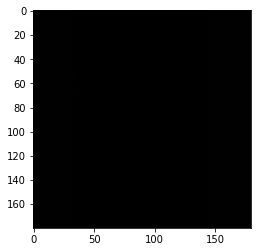

In [ ]:
plt.imshow(bx[-1].astype(np.uint8))

In [ ]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                             LIBRAIRIE
category_level2    BRICOLAGE - DECORATION - JARDINAGE
category_level3                            BRICOLAGE 
category_idx                                     3259
Name: 1000014058, dtype: object

In [ ]:
%time bx, by = next(val_gen)

CPU times: user 429 ms, sys: 90 ms, total: 519 ms
Wall time: 1.03 s


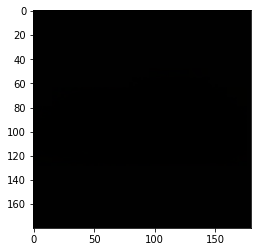

In [ ]:
plt.imshow(bx[-1].astype(np.uint8))

In [ ]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                                              SPORT
category_level2                               RUNNING - ATHLETISME
category_level3    CHAUSSURES DE RUNNING - CHAUSSURES D'ATHLETISME
category_idx                                                  4798
Name: 1000018838, dtype: object

# Part 3: Training

Create a very simple Keras model and train it, to test that the generators work.

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
__________

In [ ]:
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = 50,   #num_train_images // batch_size,
                    epochs = 1,
                    validation_data = val_gen,
                    validation_steps = 10,  #num_val_images // batch_size,
                    workers = 8)

Epoch 1/1


50/50 [==============================] - 564s - loss: 7.4456 - acc: 0.0059 - val_loss: 15.9462 - val_acc: 0.0050


In [ ]:
model.save('/content/model',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
from keras.models import load_model
demo = load_model('/content/model')

In [ ]:
# To train the model:
demo.fit_generator(train_gen,
                    steps_per_epoch = 50,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = 10,  #num_val_images // batch_size,
                    workers = 8)

Epoch 1/3
50/50 [==============================] - 363s - loss: 6.9756 - acc: 0.0076 - val_loss: 15.9178 - val_acc: 0.0073
Epoch 2/3
50/50 [==============================] - 323s - loss: 6.8859 - acc: 0.0101 - val_loss: 15.9981 - val_acc: 0.0073
Epoch 3/3
50/50 [==============================] - 342s - loss: 6.8476 - acc: 0.0113 - val_loss: 15.9943 - val_acc: 0.0067


In [ ]:
model.save('/content/model2',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
from keras.models import load_model
demo2 = load_model('/content/model2')

In [ ]:
# To train the model:
demo2.fit_generator(train_gen,
                    steps_per_epoch = 50,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = 10,  #num_val_images // batch_size,
                    workers = 8)

Epoch 1/3
29/50 [================>.............] - ETA: 138s - loss: 7.6707 - acc: 0.0054

KeyboardInterrupt: ignored

In [ ]:
# To evaluate on the validation set:
#model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)

In [ ]:
def lr_scheduler(epoch, lr):
    'For every 2nd epoch, decay learning rate by 5%'
    decay_rate = .95
    decay_step = 1
    if (epoch+1) % decay_step == 0 :
        return lr * decay_rate
    return lr


In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=1, min_lr=0.0000000003)

#lrschedule = LearningRateScheduler(lr_scheduler)

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.callbacks import Callback
from keras.callbacks import TensorBoard


In [ ]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input

In [ ]:
IMAGE_SIZE = [180, 180] #pre trained Xception model
model = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

79699968/83683744 [===========================>..] - ETA: 0s

In [ ]:
#model_1
for layer in model.layers:
  layer.trainable = False
#Adding custom Layers 
x = model.output
x = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x)
x = MaxPool2D(2,2)(x)
x = Flatten()(x)
x = Dense(500, activation="relu")(x)
x = Dense(500, activation="relu")(x)
output = Dense(5270, activation="softmax")(x)
# creating the final model 
model_1 = Model(inputs = model.input, outputs = output)
# compile the model 
Adam = keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_1.compile(loss = "categorical_crossentropy", optimizer = Adam, metrics=["accuracy"])

Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
keep_dims is deprecated, use keepdims instead



In [ ]:
model_1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 180, 180, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 89, 89, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 89, 89, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 89, 89, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# To train the model:
model_1.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 1,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Epoch 1/1
37130/37130 [==============================] - 27517s - loss: 2.9607 - acc: 0.4601 - val_loss: 2.6822 - val_acc: 0.4984


In [ ]:
model_1.save('/content/drive/MyDrive/kerasep1_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
model_1.save_weights('/content/drive/MyDrive/kerasmodelep1_weight')
print("Wights Saved")

Wights Saved


In [ ]:
from keras.models import load_model
demo2 = load_model('/content/drive/MyDrive/kerasep1_model.kerasave')





Instructions for updating:
keep_dims is deprecated, use keepdims instead






Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [ ]:
keras.backend.set_value(demo2.optimizer.lr, 0.0003)

In [ ]:
demo2.optimizer.get_config()


{'lr': 0.0003000000142492354,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
# To train the model:
demo2.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 2,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8,
                    callbacks= [reduce_lr])

Epoch 1/2
37130/37130 [==============================] - 27757s - loss: 2.5840 - acc: 0.5098 - val_loss: 2.6192 - val_acc: 0.5123

/usr/local/lib/python3.7/dist-packages/keras/callbacks.py:889: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 2/2
37130/37130 [==============================] - 27764s - loss: 2.4930 - acc: 0.5228 - val_loss: 2.5903 - val_acc: 0.5189


In [ ]:
demo2.save('/content/drive/MyDrive/kerasep3_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
model_1.save_weights('/content/drive/MyDrive/kerasmodelep3_weight')
print("Wights Saved")

In [ ]:
from keras.models import load_model
demo2 = load_model('/content/drive/MyDrive/kerasep3_model.kerasave')

In [ ]:
# To train the model:
demo2.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 2,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8,
                    callbacks= [reduce_lr])

Epoch 1/2
37130/37130 [==============================] - 27658s - loss: 2.4442 - acc: 0.5298 - val_loss: 2.5783 - val_acc: 0.5224
Epoch 2/2
37130/37130 [==============================] - 27675s - loss: 2.4123 - acc: 0.5344 - val_loss: 2.5853 - val_acc: 0.5243


In [ ]:
demo2.save('/content/drive/MyDrive/kerasep4_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
from keras.models import load_model
demo2 = load_model('/content/drive/MyDrive/kerasep5_model.kerasave')





Instructions for updating:
keep_dims is deprecated, use keepdims instead






Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [ ]:
demo2.optimizer.get_config()


{'lr': 0.0003000000142492354,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
0.0003*0.65

0.000195

In [ ]:
keras.backend.set_value(demo2.optimizer.lr, 0.000195)

In [ ]:
demo2.optimizer.get_config()

{'lr': 0.00019500000053085387,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
# To train the model:
demo2.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8,
                    callbacks= [reduce_lr])

Epoch 1/3
37130/37130 [==============================] - 27764s - loss: 2.2950 - acc: 0.5504 - val_loss: 2.5126 - val_acc: 0.5366

/usr/local/lib/python3.7/dist-packages/keras/callbacks.py:889: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 2/3
37130/37130 [==============================] - 27759s - loss: 2.2476 - acc: 0.5567 - val_loss: 2.5045 - val_acc: 0.5388
Epoch 3/3
37130/37130 [==============================] - 27760s - loss: 2.2218 - acc: 0.5600 - val_loss: 2.5071 - val_acc: 0.5404


In [ ]:
demo2.save('/content/drive/MyDrive/kerasep8_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


#lr 0.00005

In [ ]:
from keras.models import load_model
demo2 = load_model('/content/drive/MyDrive/kerasep8_model.kerasave')





Instructions for updating:
keep_dims is deprecated, use keepdims instead






Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [ ]:
demo2.optimizer.get_config()


{'lr': 0.00019500000053085387,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
keras.backend.set_value(demo2.optimizer.lr, 0.00005)

In [ ]:
demo2.optimizer.get_config()

{'lr': 4.999999873689376e-05,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
# To train the model:
demo2.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8,
                    callbacks= [reduce_lr])

Epoch 1/3
37130/37130 [==============================] - 27458s - loss: 2.0836 - acc: 0.5791 - val_loss: 2.4504 - val_acc: 0.5520
Epoch 2/3
37130/37130 [==============================] - 27392s - loss: 2.0411 - acc: 0.5849 - val_loss: 2.4418 - val_acc: 0.5532
Epoch 3/3
37130/37130 [==============================] - 27400s - loss: 2.0189 - acc: 0.5879 - val_loss: 2.4456 - val_acc: 0.5550


In [ ]:
demo2.save('/content/drive/MyDrive/kerasep11_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
from keras.models import load_model
demo2 = load_model('/content/drive/MyDrive/kerasep11_model.kerasave')

In [ ]:
demo2.optimizer.get_config()

In [ ]:
keras.backend.set_value(demo2.optimizer.lr, 0.000005)

In [ ]:
demo2.optimizer.get_config()

In [ ]:
# To train the model:
demo2.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 1,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8,
                    callbacks= [reduce_lr])

Epoch 1/1
37130/37130 [==============================] - 27535s - loss: 1.9701 - acc: 0.5944 - val_loss: 2.4383 - val_acc: 0.5569


In [ ]:
demo2.save('/content/drive/MyDrive/kerasep12_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


#n

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/kerasep12_model.kerasave')


Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 180, 180, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 89, 89, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 89, 89, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 89, 89, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

##set last 3 layer of xception net to trainable

In [ ]:
my_layer = model.get_layer('block14_sepconv2')
my_layer.trainable = True

In [ ]:
my_layer = model.get_layer('block14_sepconv2_bn')
my_layer.trainable = True

In [ ]:
my_layer = model.get_layer('block14_sepconv2_act')
my_layer.trainable = True

In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 180, 180, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 89, 89, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 89, 89, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 89, 89, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
model.optimizer.get_config()

{'lr': 4.999999873689376e-06,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
keras.backend.set_value(model.optimizer.lr, 0.0001)

In [ ]:
model.optimizer.get_config()

{'lr': 9.999999747378752e-05,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,   #num_train_images // batch_size,
                    epochs = 2,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,  #num_val_images // batch_size,
                    workers = 8,
                    callbacks= [reduce_lr])

Epoch 1/2
37130/37130 [==============================] - 27447s - loss: 2.0486 - acc: 0.5834 - val_loss: 2.4624 - val_acc: 0.5518
Epoch 2/2
37130/37130 [==============================] - 27441s - loss: 2.0400 - acc: 0.5845 - val_loss: 2.4645 - val_acc: 0.5524


In [ ]:
model.save('/content/drive/MyDrive/kerasep14_model.kerasave',include_optimizer=True)
print("Model Saved")

Model Saved


In [ ]:
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/kerasep14_model.kerasave')

/usr/local/lib/python3.7/dist-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
model2.optimizer.get_config()

{'lr': 9.999999747378752e-05,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07}

In [ ]:
keras.backend.set_value(model.optimizer.lr, 0.00005)

#Prediction

In [5]:
!kaggle competitions download -c 'cdiscount-image-classification-challenge' -f test.bson

100% 11.8G/11.8G [02:33<00:00, 74.5MB/s]
100% 11.8G/11.8G [02:33<00:00, 82.5MB/s]


In [6]:
!unzip /content/test.bson.zip

Archive:  /content/test.bson.zip
  inflating: test.bson               


In [7]:
!rm /content/test.bson.zip

In [8]:
!kaggle competitions download -c 'cdiscount-image-classification-challenge' -f sample_submission.csv

100% 4.61M/4.61M [00:00<00:00, 28.5MB/s]
100% 4.61M/4.61M [00:00<00:00, 28.4MB/s]


In [9]:
!unzip /content/sample_submission.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [10]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/kerasep12_model.kerasave')

Using TensorFlow backend.




Instructions for updating:
keep_dims is deprecated, use keepdims instead






Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [11]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import pandas as pd
import bson
import os
from collections import defaultdict
from tqdm import *
import multiprocessing as mp
import struct
import os, sys, math, io
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

num_test_products = 1768182


categories_path = os.path.join("/content/drive/Shareddrives/Case_study/cdiscount/category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

cat2idx, idx2cat = make_category_tables()

submission_df = pd.read_csv("/content/sample_submission.csv")
submission_df.head()

test_bson_path = os.path.join("/content/test.bson")

# test_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.3,
#         rotation_range=180.,
#         width_shift_range=0.3,
#         height_shift_range=0.3,
#         horizontal_flip=True)
 
test_datagen = ImageDataGenerator(
         rescale=1./255)
    
data = bson.decode_file_iter(open(test_bson_path, "rb"))

with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])
        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())
        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]
            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            #x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)
            # Add the image to the batch.
            batch_x[i] = x
        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0) # .mean
        cat_idx = np.argmax(avg_pred)
        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()

submission_df.to_csv("final_submission.csv.gz", compression="gzip", index=False)

100%|██████████| 1768182/1768182 [7:40:13<00:00, 64.03it/s]


In [12]:
import shutil
  
# Source path 100006949  
source = "/content/final_submission.csv.gz"
  
# Destination path
destination = "/content/drive/MyDrive"
  
# Move the content of
# source to destination
dest = shutil.move(source, destination)
print('done') 

done
